In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-blossom-flower-classification/cat_to_name.json
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/aa5.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/ab58.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/au54.jpeg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/au56.jpeg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/nic22.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/mh26.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/gc21.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/nic23.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/au52.jpeg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/au33.jpg
/kaggle/input/hackathon-blossom-flower-classification/test set/test set/ac14.jpg
/kaggle/input/hackathon-blossom-fl

In [2]:
!pip install captum

     |████████████████████████████████| 1.4 MB 595 kB/s eta 0:00:01


<hr style="border: solid 3px blue;">

# Introduction

![Transfer Learning](https://miro.medium.com/max/1400/1*lUyfhgm9mzEmtXWfxbp17w.gif)

Picture Credit: https://miro.medium.com

**Why transfer learning?**

* Training a convolution network from scratch is time-consuming and resource-intensive.
* The more complex the model, the harder it is to train.
* It takes a lot of effort to actually learn from scratch.
* Finally, everything except the fully connected layer is used as a fixed feature extractor.
* Define a new final classifier layer and apply it to training.

-----------------------------------------
# Importing library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as TF

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from torchvision.utils import make_grid
from torchvision import models as models 
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [5]:
input_dir = '../input/flowers-recognition/flowers/'

In [6]:
#check models which are supported
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

# Transforming the Data

In order to perform transfer learning using a pre-trained model, images must be appropriately preprocessed. 224 x 224 images is used as input. Therefore, the input flower image must also be resized to the corresponding size.

In [7]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

database = datasets.ImageFolder(input_dir, transform=data_transform)
test_size = 500
training_size = len(database) - test_size
train_ds, test_ds = random_split(database, [training_size, test_size])

# print out some data stats
print('Num training images: ', len(train_ds))
print('Num test images: ', len(test_ds))


Num training images:  3817
Num test images:  500


In [8]:
classes = database.classes
print(classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# Loading Data using DataLoaders

In [9]:
# define dataloader parameters
batch_size = 10
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Visualizing some sample data

In [10]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]],fontsize=30)

--------------------------------------------------------------
# Defining the Model

**Create the model in the following order:**

1. Load the pre-trained model.
2. All weight information is "freeze" for use as a fixed feature extractor.
3. The last fully connected layer is deleted.
4. Change the last Classifier to be suitable for classifying flower images.

Freezing the weight means that the weight information in the pre-trained model is not updated during training.

In [11]:
# Load the pretrained model from pytorch
m_v2 = models.mobilenet_v2(pretrained=True)

# print out the model structure
#print(m_v2)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [12]:
print(m_v2.classifier[1].in_features) 
print(m_v2.classifier[1].out_features) 

1280
1000


In [13]:
# Freeze training for all "features" layers
for param in m_v2.features.parameters():
    param.requires_grad = False

# Add Final Classifier Layer
If you have set the pre-trained feature extractor, add a fully-connected layer as the last classifier.

In [14]:
import torch.nn as nn

n_inputs = m_v2.classifier[1].in_features

last_layer = nn.Linear(n_inputs, len(classes))

m_v2.classifier[1] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    m_v2.cuda()

# check that the last layer
print(m_v2.classifier[1].out_features)
print(m_v2)

5
MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=

# Defining Loss Function and Optimizer
We use cross-entropy loss and stochastic gradient descent. Choose the learning rate appropriately.


In [15]:
import torch.optim as optim

# define loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(m_v2.classifier.parameters(), lr=0.01)

# Training

In [16]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = m_v2(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 2.1539397984743118
Epoch 1, Batch 40 loss: 1.1797137439250946
Epoch 1, Batch 60 loss: 1.2960729181766510
Epoch 1, Batch 80 loss: 1.3157767340540887
Epoch 1, Batch 100 loss: 2.1287972077727320
Epoch 1, Batch 120 loss: 1.5147369023412467
Epoch 1, Batch 140 loss: 1.0557211099658161
Epoch 1, Batch 160 loss: 1.1957110263407231
Epoch 1, Batch 180 loss: 1.1450272299349309
Epoch 1, Batch 200 loss: 1.1191749844700098
Epoch 1, Batch 220 loss: 0.9958999235183000
Epoch 1, Batch 240 loss: 1.0241598270346004
Epoch 1, Batch 260 loss: 0.9731177721172571
Epoch 1, Batch 280 loss: 2.0423898026347160
Epoch 1, Batch 300 loss: 1.4110183089971542
Epoch 1, Batch 320 loss: 1.5935884669423104
Epoch 1, Batch 340 loss: 1.5114938586950302
Epoch 1, Batch 360 loss: 1.0909133953973651
Epoch 1, Batch 380 loss: 1.2532556451857091
Epoch 2, Batch 20 loss: 1.1573184411972761
Epoch 2, Batch 40 loss: 1.5889448393136263
Epoch 2, Batch 60 loss: 1.9099340911954641
Epoch 2, Batch 80 loss: 1.6219337400980

------------------------------------------------
# Testing

In [17]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

m_v2.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = m_v2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.999819

Test Accuracy of daisy: 88% (78/88)
Test Accuracy of dandelion: 81% (97/119)
Test Accuracy of  rose: 51% (46/90)
Test Accuracy of sunflower: 88% (71/80)
Test Accuracy of tulip: 94% (116/123)

Test Accuracy (Overall): 81% (408/500)


------------------------------------------------------
# Visualizing Sample Test Results

In [18]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_np = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_np[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]],fontsize=30)

<hr style="border: solid 3px blue;">

# Interpreting Models

![](https://d33wubrfki0l68.cloudfront.net/c183cb531dbcc4e397e7645b28a5cbb2d47889ac/0e818/img/content/brainneural.gif)

Picture Credit: https://d33wubrfki0l68.cloudfront.net

We want to understand on what basis our CNN model judged the flower type. Therefore, we want to visually understand the judgment basis of our model through the following two methods.

**Saliency detection**

Saliency detection refers to separating an object of interest from a background that is not of interest, and the result is a binarized image as shown below. These detection methods help you spend less time and energy in determining the most relevant parts of an image. In other words, simplifying the representation of an image to make it more meaningful and easier to analyze.

**IntegratedGradients**

A gradient for each pixel of the generated images will appear, and integrating these gradients will show the effect on the overall pixel output. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

In [19]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [20]:
ind = 0
net = m_v2

input = images[ind].unsqueeze(0)

saliency = Saliency(m_v2)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [21]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.4567], dtype=torch.float64)


Original Image
Predicted: sunflower


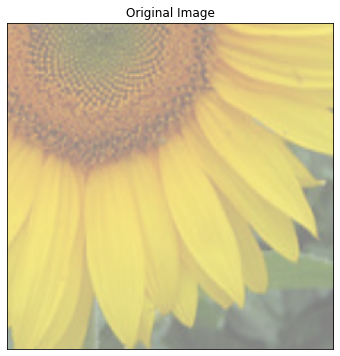

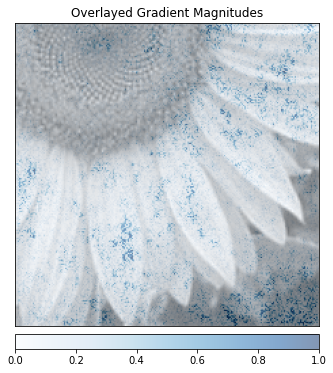

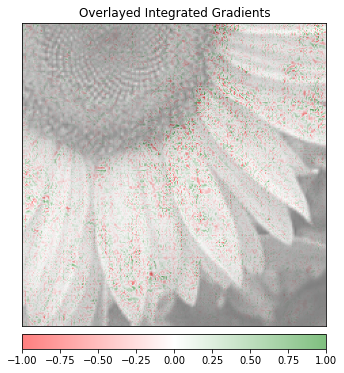

In [22]:
print('Original Image')
print('Predicted:', classes[labels[ind]])
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

<span style="color:Blue"> **Observation:**

* Our model decided that the pixels representing the characteristics of a sunflower are important. It seems reasonable.

In [23]:
ind = 5
net = m_v2

input = images[ind].unsqueeze(0)

saliency = Saliency(m_v2)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [24]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.2900], dtype=torch.float64)


Original Image
Predicted: tulip


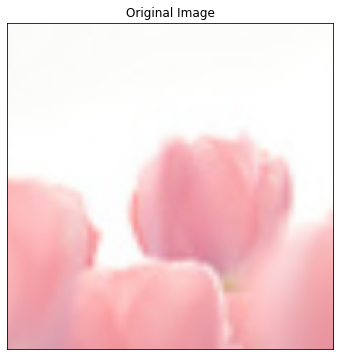

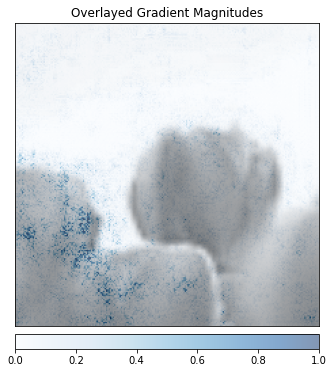

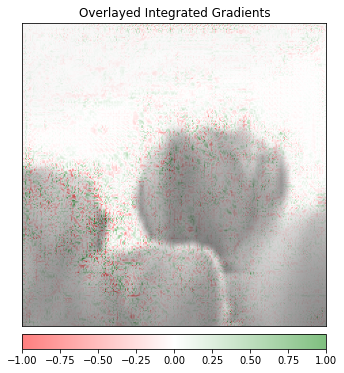

In [25]:
print('Original Image')
print('Predicted:', classes[labels[ind]])
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")


<span style="color:Blue"> **Observation:**

* Our model decided that the pixels representing the Tulip characteristics were important. It seems reasonable.